In [1]:
# Import packages and load the data
import numpy as np
import numpy.linalg as lin
import scipy.stats as sts
import scipy.integrate as intgr
import scipy.optimize as opt
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
cmap1 = matplotlib.cm.get_cmap('summer')
# This next command is specifically for Jupyter Notebook
%matplotlib notebook

inc = np.loadtxt('incomes.txt') #read in the data

<IPython.core.display.Javascript object>


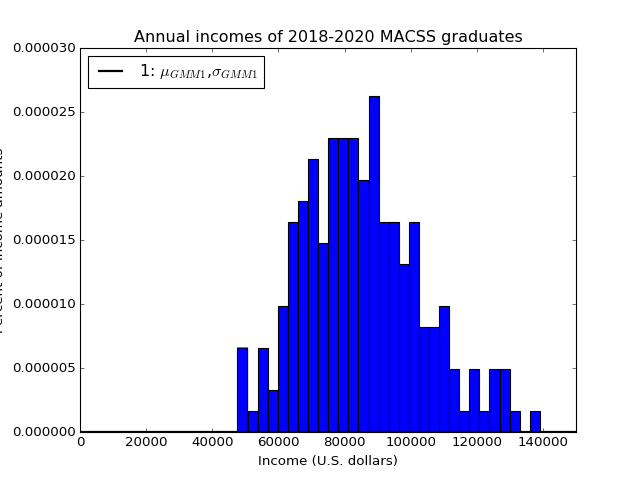

(0, 150000)

In [60]:
fig1 = plt.figure()
count, bins, ignored = plt.hist(inc, 30, normed=True)
plt.title('Annual incomes of 2018-2020 MACSS graduates')
plt.xlabel('Income (U.S. dollars)')
plt.ylabel('Percent of income amounts')
plt.xlim([0, 150000])

In [119]:
#function that generates values of lognormal pdf
def lognorm_pdf(xvals, mu, sigma):
    pdf_vals    = lognorm.pdf(xvals, s = sigma, scale = np.exp(mu))
    
    return pdf_vals

def data_moments(xvals):
    '''
    --------------------------------------------------------------------
    This function computes the two data moments for GMM
    (mean(data), std(data)).
    --------------------------------------------------------------------
    INPUTS:
    xvals = (N,) vector, test scores data
    
    OTHER FUNCTIONS AND FILES CALLED BY THIS FUNCTION: None
    
    OBJECTS CREATED WITHIN FUNCTION:
    mean_data = scalar, mean value of test scores data
    std_data  = scalar > 0, standard deviation of test scores data
    
    FILES CREATED BY THIS FUNCTION: None
    
    RETURNS: mean_data, std_data
    --------------------------------------------------------------------
    '''
    mean_data = xvals.mean()
    std_data = xvals.std()
    
    return mean_data, std_data

def model_moments(mu, sigma, cutoff):
    '''
    --------------------------------------------------------------------
    This function computes the two model moments for GMM
    (mean(model data), variance(model data)).
    --------------------------------------------------------------------
    INPUTS:
    mu     = scalar, mean of the normally distributed random variable
    sigma  = scalar > 0, standard deviation of the normally distributed
             random variable
    cutoff = scalar or string, ='None' if no cutoff is given, otherwise
             is scalar upper bound value of distribution. Values above
             this value have zero probability
    
    OTHER FUNCTIONS AND FILES CALLED BY THIS FUNCTION:
        lognorm_pdf()
        xfx()
        x2fx()
    
    OBJECTS CREATED WITHIN FUNCTION:
    mean_model = scalar, mean value of test scores from model
    m_m_err    = scalar > 0, estimated error in the computation of the
                 integral for the mean of the distribution
    var_model  = scalar > 0, variance of test scores from model
    v_m_err    = scalar > 0, estimated error in the computation of the
                 integral for the variance of the distribution
    
    FILES CREATED BY THIS FUNCTION: None
    
    RETURNS: mean_model, var_model
    --------------------------------------------------------------------
    '''
    xfx = lambda x: x * lognorm_pdf(x, mu, sigma)
    (mean_model, m_m_err) = intgr.quad(xfx, -np.inf, cutoff)
    x2fx = lambda x: ((x - mean_model) ** 2) * lognorm_pdf(x, mu, sigma)
    (var_model, v_m_err) = intgr.quad(x2fx, -np.inf, cutoff)
    std_model = sqrt(var_model)
    
    return mean_model, std_model

def err_vec(xvals, mu, sigma, cutoff, simple):
    '''
    --------------------------------------------------------------------
    This function computes the vector of moment errors (in percent
    deviation from the data moment vector) for GMM.
    --------------------------------------------------------------------
    INPUTS:
    xvals  = (N,) vector, test scores data
    mu     = scalar, mean of the normally distributed random variable
    sigma  = scalar > 0, standard deviation of the normally distributed
             random variable
    cutoff = scalar or string, ='None' if no cutoff is given, otherwise
             is scalar upper bound value of distribution. Values above
             this value have zero probability
    simple = boolean, =True if errors are simple difference, =False if
             errors are percent deviation from data moments
    
    OTHER FUNCTIONS AND FILES CALLED BY THIS FUNCTION:
        data_moments()
        model_moments()
    
    OBJECTS CREATED WITHIN FUNCTION:
    mean_data  = scalar, mean value of data
    var_data   = scalar > 0, variance of data
    moms_data  = (2, 1) matrix, column vector of two data moments
    mean_model = scalar, mean value from model
    var_model  = scalar > 0, variance from model
    moms_model = (2, 1) matrix, column vector of two model moments
    err_vec    = (2, 1) matrix, column vector of two moment error
                 functions
    
    FILES CREATED BY THIS FUNCTION: None
    
    RETURNS: err_vec
    --------------------------------------------------------------------
    '''
    mean_data, std_data = data_moments(xvals)
    moms_data = np.array([[mean_data], [std_data]])
    mean_model, std_model = model_moments(mu, sigma, cutoff)
    moms_model = np.array([[mean_model], [std_model]])
    if simple:
        err_vec = moms_model - moms_data
    else:
        err_vec = (moms_model - moms_data) / moms_data
    
    return err_vec

def criterion(params, *args):
    '''
    --------------------------------------------------------------------
    This function computes the GMM weighted sum of squared moment errors
    criterion function value given parameter values and an estimate of
    the weighting matrix.
    --------------------------------------------------------------------
    INPUTS:
    params = (2,) vector, ([mu, sigma])
    mu     = scalar, mean of the normally distributed random variable
    sigma  = scalar > 0, standard deviation of the normally distributed
             random variable
    args   = length 3 tuple, (xvals, cutoff, W_hat)
    xvals  = (N,) vector, values of the truncated normally distributed
             random variable
    cutoff = scalar or string, ='None' if no cutoff is given, otherwise
             is scalar upper bound value of distribution. Values above
             this value have zero probability
    W_hat  = (R, R) matrix, estimate of optimal weighting matrix
    
    OTHER FUNCTIONS AND FILES CALLED BY THIS FUNCTION:
        norm_pdf()
    
    OBJECTS CREATED WITHIN FUNCTION:
    err        = (2, 1) matrix, column vector of two moment error
                 functions
    crit_val   = scalar > 0, GMM criterion function value
    
    FILES CREATED BY THIS FUNCTION: None
    
    RETURNS: crit_val
    --------------------------------------------------------------------
    '''
    mu, sigma = params
    xvals, cutoff, W = args
    err = err_vec(xvals, mu, sigma, cutoff, simple=False)
    crit_val = np.dot(np.dot(err.T, W), err) 
    
    return crit_val

C:\Users\owlyp\Anaconda3\lib\site-packages\scipy\integrate\quadpack.py:356: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  warnings.warn(msg, IntegrationWarning)
C:\Users\owlyp\Anaconda3\lib\site-packages\scipy\integrate\quadpack.py:356: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  warnings.warn(msg, IntegrationWarning)


Value of GMM criterion: 0.0611646544251
mu_GMM1= 11.0048359601  sig_GMM1= 0.405010003046
Mean of points = 85276.8236063 , Standard deviation of points = 17992.542128
Mean of model = 65775.27744921781 , Standard deviation of model = 19686.8761113
Error vector= [-0.22868518  0.09416868]


<IPython.core.display.Javascript object>


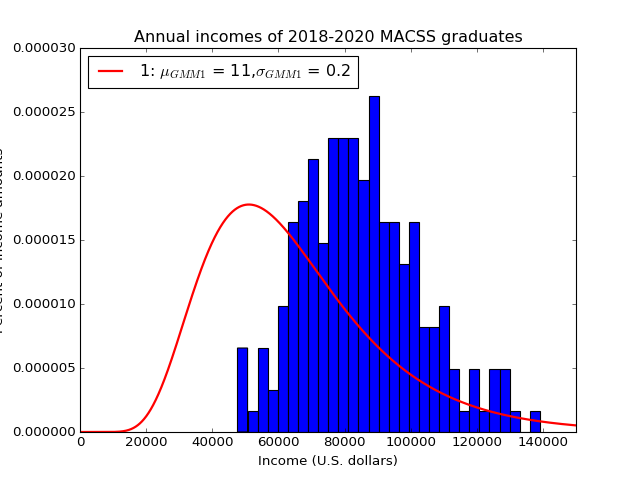

array([  47628.56063612,   50676.92033321,   53725.28003029,
         56773.63972738,   59821.99942447,   62870.35912155,
         65918.71881864,   68967.07851573,   72015.43821281,
         75063.7979099 ,   78112.15760699,   81160.51730407,
         84208.87700116,   87257.23669825,   90305.59639533,
         93353.95609242,   96402.31578951,   99450.67548659,
        102499.03518368,  105547.39488077,  108595.75457785,
        111644.11427494,  114692.47397203,  117740.83366912,
        120789.1933662 ,  123837.55306329,  126885.91276038,
        129934.27245746,  132982.63215455,  136030.99185164,
        139079.35154872])

In [123]:
# Note that this takes a little time because the intgr.quad() commands
# are a little slow
#mu_init = 11.3
#sig_init = 0.212
mu_init = 11
sig_init = 0.2
params_init = np.array([mu_init, sig_init])
W_hat = np.eye(2)
gmm_args = (inc, 150000, W_hat)
results = opt.minimize(criterion, params_init, args=(gmm_args),
                       method='L-BFGS-B', bounds=((1e-10, None), (1e-10, None)))
mu_GMM1, sig_GMM1 = results.x
params_GMM1 = np.array([mu_GMM1, sig_GMM1])
GMMcrit = criterion(params_GMM1, *gmm_args)[0][0]
#criterion(params_init, gmm_args)[0][0]

print('Value of GMM criterion:', GMMcrit)
print('mu_GMM1=', mu_GMM1, ' sig_GMM1=', sig_GMM1)

mean_data, std_data = data_moments(inc)
mean_model, std_model = model_moments(mu_GMM1, sig_GMM1, 150000)
err1 = err_vec(inc, mu_GMM1, sig_GMM1, 150000, False).reshape(2,)
print('Mean of points =', mean_data, ', Standard deviation of points =', std_data)
print('Mean of model =', mean_model, ', Standard deviation of model =', std_model)
print('Error vector=', err1)
results

# Plot the estimated GMM PDF
fig2 = plt.figure()
count, bins, ignored = plt.hist(inc, 30, normed=True)
plt.title('Annual incomes of 2018-2020 MACSS graduates')
plt.xlabel('Income (U.S. dollars)')
plt.ylabel('Percent of income amounts')
plt.xlim([0, 150000])

inc_pts = np.linspace(0, 150000, 150000)
plt.plot(inc_pts, lognorm_pdf(inc_pts, mu_GMM1, sig_GMM1),
         linewidth=2, color='r', label='1: $\mu_{GMM1}$ = 11,$\sigma_{GMM1}$ = 0.2')
plt.legend(loc='upper left')
bins

<IPython.core.display.Javascript object>


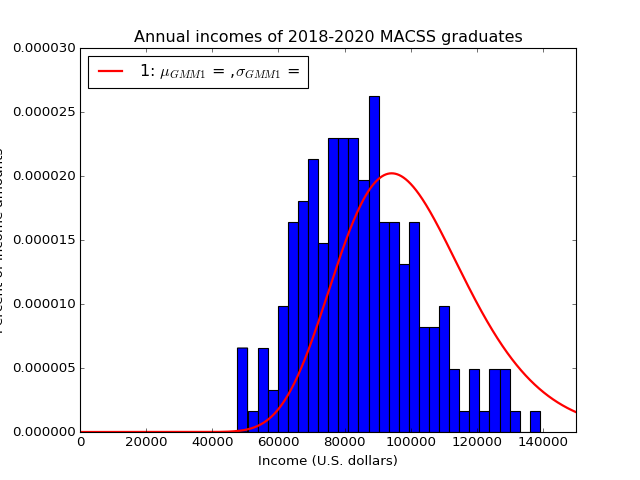

array([  47628.56063612,   50676.92033321,   53725.28003029,
         56773.63972738,   59821.99942447,   62870.35912155,
         65918.71881864,   68967.07851573,   72015.43821281,
         75063.7979099 ,   78112.15760699,   81160.51730407,
         84208.87700116,   87257.23669825,   90305.59639533,
         93353.95609242,   96402.31578951,   99450.67548659,
        102499.03518368,  105547.39488077,  108595.75457785,
        111644.11427494,  114692.47397203,  117740.83366912,
        120789.1933662 ,  123837.55306329,  126885.91276038,
        129934.27245746,  132982.63215455,  136030.99185164,
        139079.35154872])

<IPython.core.display.Javascript object>


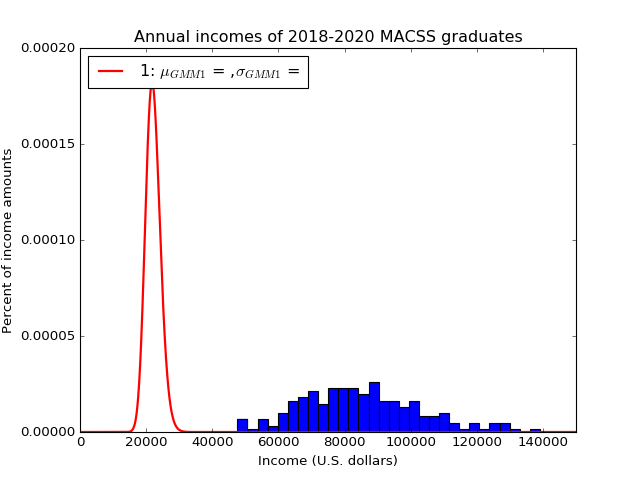

array([  47628.56063612,   50676.92033321,   53725.28003029,
         56773.63972738,   59821.99942447,   62870.35912155,
         65918.71881864,   68967.07851573,   72015.43821281,
         75063.7979099 ,   78112.15760699,   81160.51730407,
         84208.87700116,   87257.23669825,   90305.59639533,
         93353.95609242,   96402.31578951,   99450.67548659,
        102499.03518368,  105547.39488077,  108595.75457785,
        111644.11427494,  114692.47397203,  117740.83366912,
        120789.1933662 ,  123837.55306329,  126885.91276038,
        129934.27245746,  132982.63215455,  136030.99185164,
        139079.35154872])

In [38]:
mean = data_moments(inc)[0]
std = data_moments(inc)[1]
xfx = lambda x: x * lognorm.pdf(inc, s = sigma, scale = np.exp(mean))
(mean_model, m_m_err) = intgr.quad(xfx, -np.inf, 150000)

C:\Users\owlyp\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: RuntimeWarning: overflow encountered in exp
  app.launch_new_instance()


error: Supplied function does not return a valid float.

In [33]:
from scipy.stats import lognorm
model_moments(data_moments(inc)[0], data_moments(inc)[1], max(inc))

C:\Users\owlyp\Anaconda3\lib\site-packages\ipykernel\__main__.py:33: RuntimeWarning: overflow encountered in exp


error: Supplied function does not return a valid float.

In [23]:
max(inc)

139079.35154872289

In [31]:
from numpy import sqrt
x = 4
sqrt(4)
y = [4,16]
sqrt(y)
y.sqrt

AttributeError: 'list' object has no attribute 'sqrt'

In [43]:
def model_moments(mu, sigma, cutoff): 
    xfx = lambda x: x * lognorm.pdf(x, s = sigma, scale = np.exp(mu))
    (mean_model, m_m_err) = intgr.quad(xfx, 0, cutoff) #taking the integral of xfx from negative infinity to the cutoff
    x2fx = lambda x: ((x - mean_model) ** 2) * lognorm.pdf(x, s = sigma, scale = np.exp(mu)) # define function getting the variance 
    (std_model, s_m_err) = sqrt(intgr.quad(x2fx, 0, cutoff))
    
    return mean_model, np.sqrt(std_model)

In [44]:
model_moments(mean, std, 150000)

C:\Users\owlyp\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
C:\Users\owlyp\Anaconda3\lib\site-packages\ipykernel\__main__.py:4: RuntimeWarning: overflow encountered in exp


(0.0, 0.0)

testing chealsea's code

In [45]:
def lognormPDF(x, mu, sigma):
    pdf_vals    = (1/(x * sigma * np.sqrt(2 * np.pi))) *\
    np.exp( - (np.log(x) - mu)**2 / (2 * sigma**2))    
    return pdf_vals

def data_moments(xvals):
    mean_data = xvals.mean()
    std_data = xvals.std()
    return mean_data, std_data

def model_moments(mu, sigma):
    #function is creating the mean and variance of the model (of the PDF) 
    xfx = lambda x: x * lognormPDF(x, mu, sigma) # define function getting the mean 
    (mean_model, m_m_err) = intgr.quad(xfx, 0, 150000) #taking the integral of xfx from negative infinity to the cutoff
    x2fx = lambda x: ((x - mean_model) ** 2) * lognormPDF(x, mu, sigma) # define function getting the variance 
    (std_model, v_m_err) = intgr.quad(x2fx, 0, 150000) 
    return mean_model, np.sqrt(std_model)
